In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import json
from collections import defaultdict, Counter
from itertools import combinations
from tabulate import tabulate


In [2]:
stats_df = pd.read_csv('./dsl_statistics.csv', index_col='Index')
manual_df = pd.read_csv('./manual_dsl_statistics.csv')

stats_df = stats_df.merge(manual_df, on='game_name')

In [3]:
stats_df.loc[stats_df.terminal_exists.isna(), 'terminal_exists'] = False

room = np.zeros((len(stats_df),), dtype=np.int)
room[['medium' in d for d in stats_df.domain_name]] = 1
room[['many' in d for d in stats_df.domain_name]] = 2

room_name = ['Few'] * len(stats_df)
stats_df = stats_df.assign(room=room, room_name=room_name)

stats_df.loc[['medium' in d for d in stats_df.domain_name], 'room_name'] = 'Medium'
stats_df.loc[['many' in d for d in stats_df.domain_name], 'room_name'] = 'Many'

def average_list_series(df, name):
    avg = np.empty_like(df[name])
    avg[:] = np.NaN
    for i, entry in df[name].iteritems():
        if isinstance(entry, str):
            avg[i] = np.fromstring(entry[1:-1], sep=',', dtype=np.int).mean()

    return df.assign(**{f'average_{name}': avg})

stats_df = average_list_series(stats_df, 'length_of_then')
stats_df = average_list_series(stats_df, 'setup_objects_quantified')
stats_df = average_list_series(stats_df, 'preference_objects_quantified')

In [4]:
REORDERED_COLUMNS = ['game_name', 'domain_name', 'room', 'room_name',
    'num_preferences',
    'length_of_then', 'average_length_of_then',
    'setup_objects_quantified', 'average_setup_objects_quantified',
    'preference_objects_quantified', 'average_preference_objects_quantified',
    'terminal_exists', 'object_types_quantified', 'is_throwing',
    'is_construction', 'difficulty', 'first_time_points',  
]
stats_df = stats_df.reindex(columns=REORDERED_COLUMNS)

In [5]:
DIFFICULTIES = ('Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard')
ROOM_NAMES = ('Few', 'Medium', 'Many')

In [6]:
stats_df.head()

,game_name,domain_name,room,room_name,num_preferences,length_of_then,average_length_of_then,setup_objects_quantified,average_setup_objects_quantified,preference_objects_quantified,average_preference_objects_quantified,terminal_exists,object_types_quantified,is_throwing,is_construction,difficulty,first_time_points
0,few-objects-2,few-objects-room-v1,0,Few,2,"[3, 3]",3,[2],2,"[3, 2]",2.5,False,"{'hexagonal_bin': 3, 'chair': 2, 'dodgeball': 2}",1,0,2,10.0
1,few-objects-3,few-objects-room-v1,0,Few,2,NaN,NaN,[1],1,"[1, 1]",1,False,"{'desktop': 1, 'laptop': 1, 'cube_block': 2}",0,1,5,1.0
2,few-objects-4,few-objects-room-v1,0,Few,1,[3],3,[2],2,[3],3,True,"{'wall': 2, 'hexagonal_bin': 2, 'dodgeball': 1}",1,0,2,14.0
3,few-objects-5,few-objects-room-v1,0,Few,2,"[3, 3]",3,[4],4,"[4, 1]",2.5,True,"{'curved_wooden_ramp': 2, 'hexagonal_bin': 2, ...",1,0,4,3.0
4,few-objects-7,few-objects-room-v1,0,Few,1,[3],3,[2],2,[3],3,False,"{'curved_wooden_ramp': 2, 'hexagonal_bin': 2, ...",1,0,1,5.0


# Readme:
* `game_name`: room-\[row number in my spreadsheet\].
* `domain_name`: the room identifier as it's iun the games (domain is a PDDL thing)
* `length_of_then`: average length of all `then` clauses in this game.
* `num_preferences`: how many preferences I used to represent the game.
* `setup/preference_objects_quantified`: average number of objects quantified over in quantifiers (`exists`/`forall`) in the game representation, split by which section of the game it's in.
* `terminal_exists`: whether the game uses a `terminal` clause.
* `object_types_quantified`: how many times each object type was quantified in each game, combined between the setup and preferences. 
* `is_throwing/construction`: a manual labeling I provided by reviewing the game. Most games are either, some are both, some are neither. I decided that construction games are only those involving construction in the actual gameplay ("build a tower to max height"), and not those where there's some element of construction in the setup ("stack blocks and then throw a ball to knock them over"). We could discuss/change this classification.
* `difficuly/first_time_points`: data we collected from the participants about their games. The `DIFFICULTIES` variables above decodes, but 1 is "very easy", 5 is "very hard", and the rest follow.
* `room/room_name`: simplifications of the room designation from the game/domain names to ease working with the data.

## Participant rating vs. ther difficulty listed

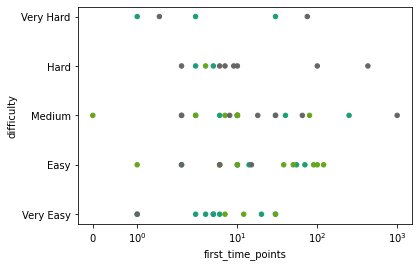

In [7]:
ax = stats_df.plot(x='first_time_points', y='difficulty', kind='scatter', c='room', colormap='Dark2', colorbar=False, logx='sym', yticks=np.arange(1, 6))
ax.set_yticklabels(DIFFICULTIES)
plt.show()

## Number of preferences histogram by room type

<AxesSubplot:title={'center':'Number of Preferences'}, ylabel='Frequency'>

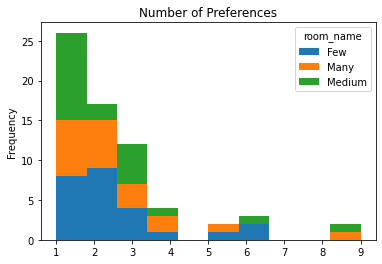

In [8]:
stats_df.pivot(columns='room_name').num_preferences.plot(kind='hist', stacked=True, title='Number of Preferences')

## Average number of objects quantified in the setup/preferences

In [9]:
def data_from_list_strings(df, name):
    data = [[] for _ in range(len(df.room.unique()))]
    for _, (entry, room_num) in stats_df.loc[:, (name, 'room')].iterrows():
        if isinstance(entry, str):
            data[room_num].extend(np.fromstring(entry[1:-1], sep=',', dtype=np.int))

    return data

def stacked_bar_chart_from_lists(df, name):
    fig, ax = plt.subplots(figsize=(8, 6))
    data = data_from_list_strings(df, name)
    counters = [Counter(d) for d in data]

    x_min = min([min(c.keys()) for c in counters])
    x_max = max([max(c.keys()) for c in counters])
    start = Counter({x:0 for x in range(x_min, x_max + 1)})

    for i, counter in enumerate(counters):
        x_locs = list(sorted(counter.keys()))
        data = [counter[x] for x in x_locs]
        ax.bar(x_locs, data, bottom=[start[x] for x in x_locs], label=stats_df.room_name.unique()[i])
        start += counter
    
    ax.set_xlabel(name)
    ax.set_ylabel('Count')
    plt.legend(loc='upper right')
    ticks = np.arange(x_min, x_max + 2)
    ax.set_xticks(ticks)
    ax.set_title(name.replace('_', ' ').title())

    plt.show()



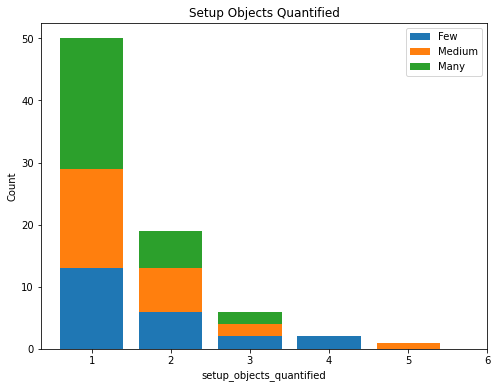

In [10]:
stacked_bar_chart_from_lists(stats_df, 'setup_objects_quantified')

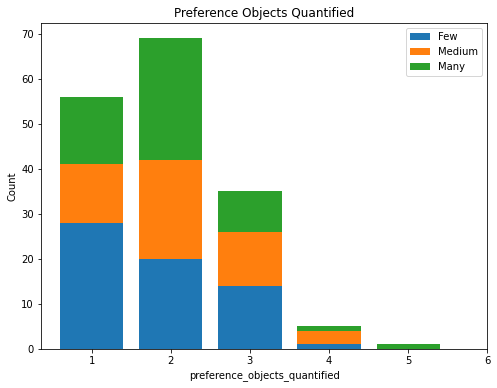

In [11]:
stacked_bar_chart_from_lists(stats_df, 'preference_objects_quantified')

## Average length of 'then' clauses

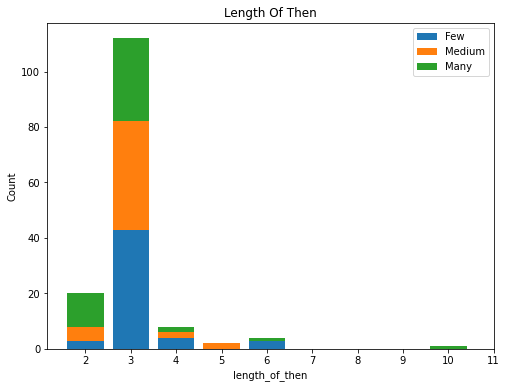

In [12]:
stacked_bar_chart_from_lists(stats_df, 'length_of_then')


## Parsing the types/counts of objects quantified

In [13]:
results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))
coocurrence_results = defaultdict(lambda: defaultdict(lambda: 0))


for i, (object_types, room_name) in stats_df.loc[:, ('object_types_quantified', 'room_name')].iterrows():
    object_types = json.loads(object_types.replace("'", '"'))
    for obj_type, count in object_types.items():
        results[obj_type][room_name]['games'] += 1
        results[obj_type][room_name]['references'] += count

    types = list(object_types.keys())
    for first_type, second_type in combinations(types, 2):
        coocurrence_results[first_type][second_type] += 1
        coocurrence_results[second_type][first_type] += 1

result_rows = []
for obj_type, obj_results in results.items():
    for room_name, room_results in obj_results.items():
        result_rows.append((obj_type, room_name, room_results['games'], room_results['references']))

object_counts_df = pd.DataFrame.from_records(result_rows, 
    columns=('object_type', 'room_name', 'games', 'references'))
object_counts_df.head()

all_object_types = object_counts_df.object_type.unique()
n_object_types = len(all_object_types)
object_type_cocurrence = np.zeros((n_object_types, n_object_types), dtype=np.int)
object_type_to_id = {obj_type:i for i, obj_type in enumerate(all_object_types)}

for first_obj_type, first_obj_results in coocurrence_results.items():
    for second_obj_type, count in first_obj_results.items():
        object_type_cocurrence[object_type_to_id[first_obj_type]][object_type_to_id[second_obj_type]] = count

    

# Readme
* `object_type`: the type of the object
* `room_name`: as above, the name of the room by the number of items
* `games`: how many games (for this room) refer to this object at least once, as part of quantifiers (`exists`/`forall`).
* `references`: how many total references appear to this object type in quantifiers in games of this type. 
* **Important**: I realize now that this undercounts -- since it only looks in references, and doesn't look in places where we directly refer to a non-quantified object (such as the desk or bed). I should think about how to fix that.

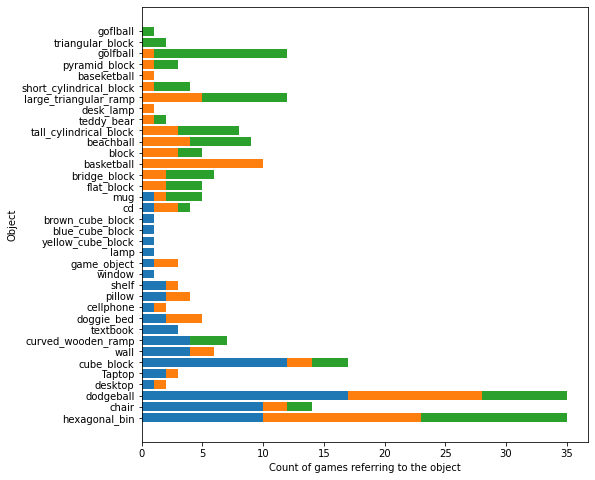

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

cumulative_start = defaultdict(lambda: 0)

for room_name in object_counts_df.room_name.unique():
    room_data = object_counts_df.loc[object_counts_df.room_name == room_name, ('object_type', 'games')]
    current_start = [cumulative_start[obj] for obj in room_data.object_type]
    ax.barh(room_data.object_type, room_data.games, left=current_start, label=room_name)

    for i, (obj, count) in room_data.iterrows():
        cumulative_start[obj] += count

ax.set_xlabel('Count of games referring to the object')
ax.set_ylabel('Object')
plt.show()

## Would the above be more interesting as...?**
* Fraction of the games that referred to the item?
    * ... from the games that could (that is, from the ones that had the type of object in the room)
* Counting the total quantifications, instead of only the number of games that refer to a particular type?
    * Graph with the total quantifications below:
* Makes some sort of aggregation? Balls, blocks, etc.?
* Separated between setup and preferences?
* **Important**: I realize now that this undercounts -- since it only looks in references, and doesn't look in places where we directly refer to a non-quantified object (such as the desk or bed). I should think about how to fix that.


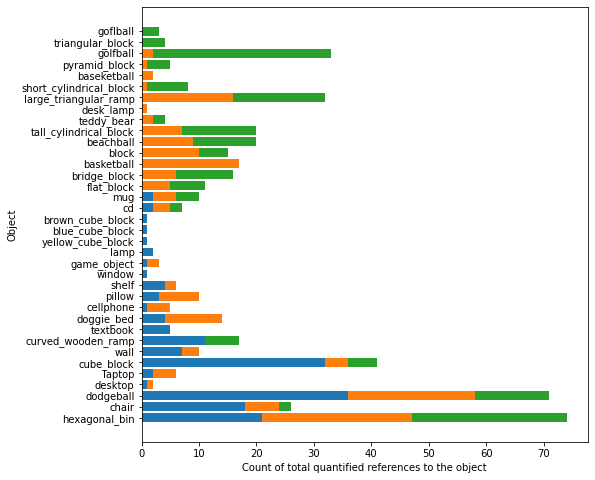

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

cumulative_start = defaultdict(lambda: 0)

for room_name in object_counts_df.room_name.unique():
    room_data = object_counts_df.loc[object_counts_df.room_name == room_name, ('object_type', 'references')]
    current_start = [cumulative_start[obj] for obj in room_data.object_type]
    ax.barh(room_data.object_type, room_data.references, left=current_start, label=room_name)

    for i, (obj, count) in room_data.iterrows():
        cumulative_start[obj] += count

ax.set_xlabel('Count of total quantified references to the object')
ax.set_ylabel('Object')
plt.show()

## Co-ocurrence between different objects (within a game)

* Would this be more interesting as within a particular quantification (exists/forall)? 
* Or split by setup and preferences?

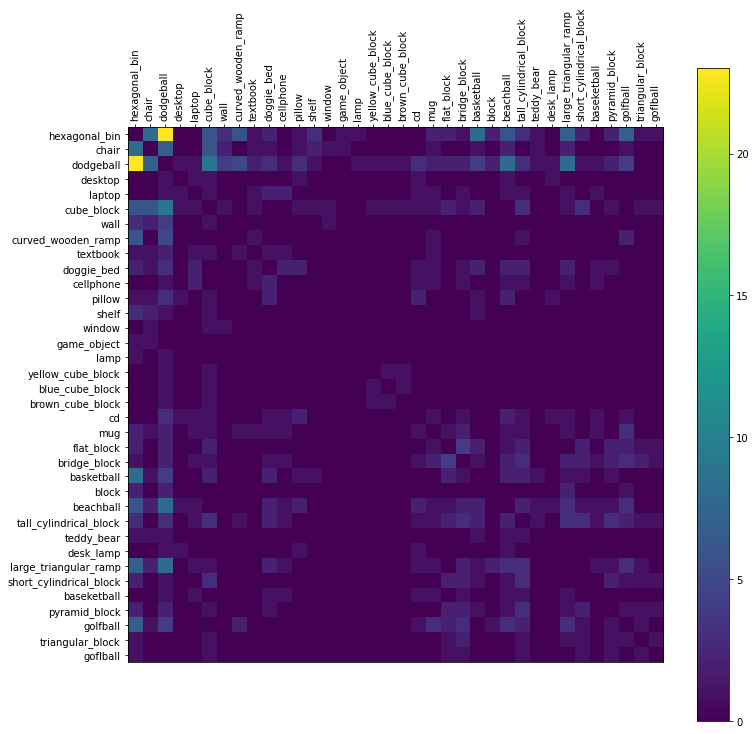

In [16]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
plt.imshow(object_type_cocurrence)
plt.xticks(np.arange(n_object_types), all_object_types, rotation='vertical')
ax.xaxis.set_ticks_position('top')
plt.yticks(np.arange(n_object_types), all_object_types)
plt.colorbar()
plt.show()

## Same as above, but sorted by count

Loses some of the block structure, but gains a better sense of the important and recurring objects

In [17]:
ocurrence_counts = object_type_cocurrence.sum(axis=0)
desc_order = np.argsort(ocurrence_counts)[::-1]
sorted_object_type_cocurrence = np.zeros_like(object_type_cocurrence)

for i in range(sorted_object_type_cocurrence.shape[0]):
    sorted_object_type_cocurrence[i, :] = object_type_cocurrence[desc_order[i], desc_order]

sorted_object_types = all_object_types[desc_order]

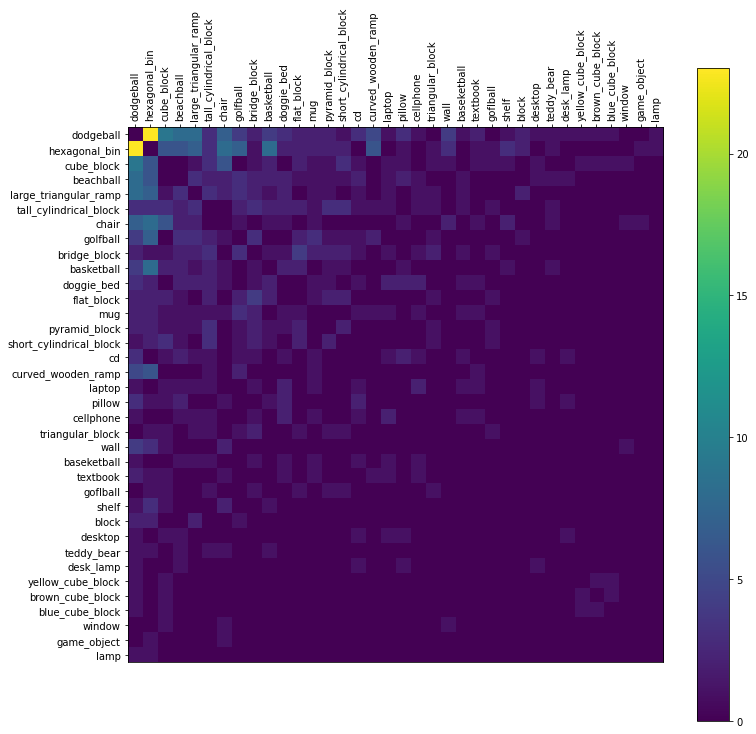

In [18]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
plt.imshow(sorted_object_type_cocurrence)
plt.xticks(np.arange(n_object_types), sorted_object_types, rotation='vertical')
ax.xaxis.set_ticks_position('top')
plt.yticks(np.arange(n_object_types), sorted_object_types)
plt.colorbar()
plt.show()

## Correlation table and p-values

In [19]:
NUMERIC_COLUMNS = [
    'room', 'average_length_of_then', 'average_setup_objects_quantified', 'average_preference_objects_quantified',
    'terminal_exists', 'is_throwing', 'is_construction', 'difficulty', 'first_time_points'
]

numeric_df = stats_df[NUMERIC_COLUMNS]
numeric_df.loc[:, 'terminal_exists'] = numeric_df.terminal_exists.astype(np.float)

arr = numeric_df.to_numpy(dtype=np.float)
nan_masked_arr = np.ma.masked_invalid(arr)
corr = np.ma.corrcoef(nan_masked_arr, rowvar=False)
corr_df = pd.DataFrame(corr, columns=numeric_df.columns, index=numeric_df.columns)
corr_df

/Users/guydavidson/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,room,average_length_of_then,average_setup_objects_quantified,average_preference_objects_quantified,terminal_exists,is_throwing,is_construction,difficulty,first_time_points
room,1.000000,-0.018131,-0.238691,0.008541,-0.095310,-0.047807,-0.052120,0.291468,0.192349
average_length_of_then,-0.018131,1.000000,0.124185,0.377814,-0.043184,-0.109090,0.066840,0.110354,-0.103791
average_setup_objects_quantified,-0.238691,0.124185,1.000000,0.335647,0.176447,0.036706,-0.182130,0.208112,-0.103175
average_preference_objects_quantified,0.008541,0.377814,0.335647,1.000000,-0.203523,0.380623,-0.464729,-0.150855,-0.057791
terminal_exists,-0.095310,-0.043184,0.176447,-0.203523,1.000000,0.274886,-0.153348,0.084197,0.268556
is_throwing,-0.047807,-0.109090,0.036706,0.380623,0.274886,1.000000,-0.716328,-0.117246,0.098238
is_construction,-0.052120,0.066840,-0.182130,-0.464729,-0.153348,-0.716328,1.000000,0.169463,-0.092510
difficulty,0.291468,0.110354,0.208112,-0.150855,0.084197,-0.117246,0.169463,1.000000,0.092218
first_time_points,0.192349,-0.103791,-0.103175,-0.057791,0.268556,0.098238,-0.092510,0.092218,1.000000


In [20]:
n_rows = nan_masked_arr.shape[1]
n = np.zeros((n_rows, n_rows), dtype=np.int)

for i in range(n_rows):
    for j in range(i, n_rows):
        n[i, j] = n[j, i] = np.invert(nan_masked_arr.mask[:,[i, j]].any(axis=1)).sum()

n

t_stat = corr.data * np.sqrt(n - 2) / np.sqrt(1 - (corr.data ** 2))
t_stat[np.diag_indices(t_stat.shape[0])] = 0
p_values = stats.t(n - 2).sf(np.abs(t_stat)) * 2

<ipython-input-20-4b5b89404fdf>:10: RuntimeWarning: divide by zero encountered in true_divide
  t_stat = corr.data * np.sqrt(n - 2) / np.sqrt(1 - (corr.data ** 2))


### P-values

In [21]:
output_p_values = []
for i, row in enumerate(p_values):
    output_p_values.append([corr_df.columns[i]] + [f'{p:1.4f}{"*" if p < 0.05 else ""}{"*" if p < 0.01 else ""}{"*" if p < 0.001 else ""}' for p in row])

headers = [""] + corr_df.columns
tabulate(output_p_values, headers, tablefmt='html')

,room,average_length_of_then,average_setup_objects_quantified,average_preference_objects_quantified,terminal_exists,is_throwing,is_construction,difficulty,first_time_points
room,1.0000,0.8897,0.1061,0.9457,0.4465,0.7031,0.6777,0.0176*,0.1218
average_length_of_then,0.8897,1.0000,0.4219,0.0027**,0.7411,0.4026,0.6088,0.3972,0.4260
average_setup_objects_quantified,0.1061,0.4219,1.0000,0.0211*,0.2355,0.8065,0.2205,0.1604,0.4901
average_preference_objects_quantified,0.9457,0.0027**,0.0211*,1.0000,0.1012,0.0016**,0.0001***,0.2266,0.6449
terminal_exists,0.4465,0.7411,0.2355,0.1012,1.0000,0.0255*,0.2190,0.5015,0.0292*
is_throwing,0.7031,0.4026,0.8065,0.0016**,0.0255*,1.0000,0.0000***,0.3485,0.4326
is_construction,0.6777,0.6088,0.2205,0.0001***,0.2190,0.0000***,1.0000,0.1737,0.4600
difficulty,0.0176*,0.3972,0.1604,0.2266,0.5015,0.3485,0.1737,1.0000,0.4615
first_time_points,0.1218,0.4260,0.4901,0.6449,0.0292*,0.4326,0.4600,0.4615,1.0000


\* < 0.05, \** < 0.01, *** < 0.001